![NVIDIA Logo](images/nvidia.png)

# PubMedQA With Few-Shot Prompts

In this notebook we continue establishing a baseline on PubMedQA before performing PEFT, but this time with few-shot prompting.

---

## Learning Objectives

By the time you complete this notebook you will:
- Format the PubMedQA data for few-shot prompting.
- Evaluate few-shot performance for all 3 models across our entire test data.

---

## Imports

In [1]:
import json
import random

from tqdm.notebook import tqdm

from llm_utils.nemo_service_models import NemoServiceBaseModel
from llm_utils.models import PubmedModels
from llm_utils.helpers import plot_experiment_results, accuracy_score
from llm_utils.pubmedqa import generate_prompt_and_answer, strip_response
from llm_utils.prompt_creators import create_prompt_with_examples, create_nemo_prompt_with_examples

---

## List Models

In [2]:
PubmedModels.list_models()

gpt8b: gpt-8b-000
gpt20b: gpt20b
gpt43b: gpt-43b-001


---

## Load Test Data

We begin again by loading our `prompts_and_answers` data.

In [3]:
prompts_and_answers = json.load(open('data/pubmedqa_panda_test.json','r'))

---

## Make Examples for Few-shot Prompting

We are going to perform 3-shot prompting with one shot for each of the 3 possible responses. `pop_prompt_by_label` will find the first instance of a label, pop it out of the list and return it.

In [4]:
def pop_prompt_by_label(prompts_list, label):
    for i, (prompt, prompt_label) in enumerate(prompts_list):
        if prompt_label == label:
            return prompts_list.pop(i)
    return None

### Check Data Length

We start with 150 samples

In [5]:
len(prompts_and_answers)

150

In [6]:
prompts_and_answers[:5]

[["OBJECTIVES: To determine the effect of the 2008 English public antibiotic campaigns.\nMETHODS: English and Scottish (acting as controls) adults aged>or = 15 years were questioned face to face about their attitudes to and use of antibiotics, in January 2008 (1888) before and in January 2009 (1830) after the antibiotic campaigns.\nRESULTS: Among English respondents, there was a small increase in recollection of campaign posters (2009 23.7% versus 2008 19.2%; P = 0.03), but this increase was only 2.3% higher in England than in Scotland. We did not detect any improvement in either England or Scotland, or any differences between England and Scotland in the understanding of the lack of benefit of antibiotics for coughs and colds, and we found no improvement in antibiotic use. We detected a significant increase in respondents retaining leftover antibiotics. Over 20% reported discussing antibiotics with their general practitioner (GP) or nurse in the year to January 2009. The offer of a del

### Get Examples

For each of the three possible labels we pop the first instance of it into an `examples` list.

In [7]:
examples = []
for label in ['yes', 'no', 'maybe']:
    example = pop_prompt_by_label(prompts_and_answers, label)
    examples.append(example)

Here we confirm we have 3 example prompt and answer pairs, one for each of the 3 possible labels.

In [8]:
examples

[["BACKGROUND: Ageing is a growing issue for people from UK black, Asian and minority ethnic (BAME) groups. The health experiences of these groups are recognised as a 'tracer' to measure success in end of life patient-preferred outcomes that includes place of death (PoD).AIM: To examine patterns in PoD among BAME groups who died of cancer.\nMATERIAL AND METHODS: Mortality data for 93,375 cancer deaths of those aged ≥65 years in London from 2001-2010 were obtained from the UK Office for National Statistics (ONS). Decedent's country of birth was used as a proxy for ethnicity. Linear regression examined trends in place of death across the eight ethnic groups and Poisson regression examined the association between country of birth and place of death.\nRESULTS: 76% decedents were born in the UK, followed by Ireland (5.9%), Europe(5.4%) and Caribbean(4.3%). Most deaths(52.5%) occurred in hospital, followed by home(18.7%). During the study period, deaths in hospital declined with an increase 

### Confirm Examples Have Been Removed

We popped the examples out rather than copy them since we don't want to evaluate on the very prompts we are providing to the model for evaluation. Here we confirm `prompts_and_answers` has been reduced in length by 3.

In [9]:
len(prompts_and_answers)

147

---

## Generate Few-shot Prompts

As a prerequisite for this workshop we assume your familiarity with few-shot prompting, including its use with instruction fine-tuned models which benefits from shots being formatted according to the template that was used for the model's instruction fine tuning. Feel free to ask an instructor or TA if you're not familiar with this technique and have questions about what we do in this section to properly format our few-shot promnpts.

### NeMo Instruction Fine-tuned Prompt Format

We will start with GPT43B which was instruction fine-tuned. To properly format example shots for this model we've provided the helper function `create_nemo_prompt_with_examples`.

You'll notice a 3-shot prompt created by this helper function includes the addition of `User:` and `Assistant:` in various places to match GPT43B's instruction fine-tuning prompt template.

In [10]:
for prompt, _ in prompts_and_answers[:1]:
    nemo_prompt_with_examples = create_nemo_prompt_with_examples(prompt, examples)
    print(nemo_prompt_with_examples)

BACKGROUND: Ageing is a growing issue for people from UK black, Asian and minority ethnic (BAME) groups. The health experiences of these groups are recognised as a 'tracer' to measure success in end of life patient-preferred outcomes that includes place of death (PoD).AIM: To examine patterns in PoD among BAME groups who died of cancer.
MATERIAL AND METHODS: Mortality data for 93,375 cancer deaths of those aged ≥65 years in London from 2001-2010 were obtained from the UK Office for National Statistics (ONS). Decedent's country of birth was used as a proxy for ethnicity. Linear regression examined trends in place of death across the eight ethnic groups and Poisson regression examined the association between country of birth and place of death.
RESULTS: 76% decedents were born in the UK, followed by Ireland (5.9%), Europe(5.4%) and Caribbean(4.3%). Most deaths(52.5%) occurred in hospital, followed by home(18.7%). During the study period, deaths in hospital declined with an increase in ho

### Non-Instruction Fine-tuned Prompt Format

GPT20B and GPT8B are not instruction fine-tuned models, and thus we only need to provide our example prompt/response shots in a straightforward manner. We've provided the `create_prompt_with_examples` helper function to accomplish this.

In [11]:
for prompt, _ in prompts_and_answers[:1]:
    prompt_with_examples = create_prompt_with_examples(prompt, examples)
    print(prompt_with_examples)

BACKGROUND: Ageing is a growing issue for people from UK black, Asian and minority ethnic (BAME) groups. The health experiences of these groups are recognised as a 'tracer' to measure success in end of life patient-preferred outcomes that includes place of death (PoD).AIM: To examine patterns in PoD among BAME groups who died of cancer.
MATERIAL AND METHODS: Mortality data for 93,375 cancer deaths of those aged ≥65 years in London from 2001-2010 were obtained from the UK Office for National Statistics (ONS). Decedent's country of birth was used as a proxy for ethnicity. Linear regression examined trends in place of death across the eight ethnic groups and Poisson regression examined the association between country of birth and place of death.
RESULTS: 76% decedents were born in the UK, followed by Ireland (5.9%), Europe(5.4%) and Caribbean(4.3%). Most deaths(52.5%) occurred in hospital, followed by home(18.7%). During the study period, deaths in hospital declined with an increase in ho

---

## Try Few-shot Prompts

As we did in the previous notebook, we will instantiate a model instance for 3 GPT models.

`NemoServiceBaseModel` allows us to provide a function for creating prompts with examples, which will useful when performing few-shot inference with each of the models below.

In [12]:
llms = {}

In [13]:
llms['gpt8b'] = NemoServiceBaseModel(PubmedModels.gpt8b.value, create_prompt_with_examples=create_prompt_with_examples)
llms['gpt20b'] = NemoServiceBaseModel(PubmedModels.gpt20b.value, create_prompt_with_examples=create_prompt_with_examples)
llms['gpt43b'] = NemoServiceBaseModel(PubmedModels.gpt43b.value, create_prompt_with_examples=create_nemo_prompt_with_examples)

In [14]:
llms

{'gpt8b': <llm_utils.nemo_service_models.NemoServiceBaseModel at 0x7ff8dd1b0fe0>,
 'gpt20b': <llm_utils.nemo_service_models.NemoServiceBaseModel at 0x7ff8dd1b0fb0>,
 'gpt43b': <llm_utils.nemo_service_models.NemoServiceBaseModel at 0x7ff8dd1b0e30>}

Let's try the first 3 samples for each model using 3-shot prompting. You'll notice the use of `llm.create_prompts_with_examples` where each model instance will format the prompt appropriately for few-shot prompting.

In [15]:
for name, llm in llms.items():
    underline = "-"*len(name)
    print(f'{name.upper()}\n{underline}\n')
    
    for prompt, label in prompts_and_answers[:3]:
        prompt_with_examples = llm.create_prompt_with_examples(prompt, examples)
        response = llm.generate(prompt_with_examples, tokens_to_generate=1, return_type='text').strip()
        print(f'Response from model: {response}')
        print(f'Actual answer: {label}')
        correct = label == response
        print(f'Response from model correct: {correct}\n')

GPT8B
-----

Response from model: 1
Actual answer: yes
Response from model correct: False

Response from model: maybe
Actual answer: yes
Response from model correct: False

Response from model: 1
Actual answer: yes
Response from model correct: False

GPT20B
------

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True

GPT43B
------

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True

Response from model: yes
Actual answer: yes
Response from model correct: True



### Analysis

There are some interesting changes from our 0 shot prompting. While 8B still looks pretty bad we see at least one response that has the semblence of being correct. Meanwhile 20B looks to have improved a lot and 43B continues to go strong.

---

## Format Data to Use Prompts With Examples

If you recall, when using the `evaluate` method, we will be passing in a list of prompt/label pairs. To that end we need to format each prompt in `prompts_and_answers`, along with our `examples` list, into their approriate `prompt_with_examples` few-shot format.

Here we do that twice, once for the instruction fine-tuned model, and once for the others.

In [16]:
few_shot_prompts_and_answers = []
nemo_few_shot_prompts_and_answers = []

### Non-Instruction Fine-tuned Formatted Prompts With Examples

In [17]:
for prompt, answer in prompts_and_answers:
    prompt_with_examples = create_prompt_with_examples(prompt, examples)
    few_shot_prompts_and_answers.append((prompt_with_examples, answer))

### NeMo GPT Formatted Prompts With Examples

In [18]:
for prompt, answer in prompts_and_answers:
    prompt_with_examples = create_nemo_prompt_with_examples(prompt, examples)
    nemo_few_shot_prompts_and_answers.append((prompt_with_examples, answer))

### Observe Shots

Let's make sure our few-shot prompts are formatted as expected.

In [19]:
few_shot_prompts_and_answers[0]

("BACKGROUND: Ageing is a growing issue for people from UK black, Asian and minority ethnic (BAME) groups. The health experiences of these groups are recognised as a 'tracer' to measure success in end of life patient-preferred outcomes that includes place of death (PoD).AIM: To examine patterns in PoD among BAME groups who died of cancer.\nMATERIAL AND METHODS: Mortality data for 93,375 cancer deaths of those aged ≥65 years in London from 2001-2010 were obtained from the UK Office for National Statistics (ONS). Decedent's country of birth was used as a proxy for ethnicity. Linear regression examined trends in place of death across the eight ethnic groups and Poisson regression examined the association between country of birth and place of death.\nRESULTS: 76% decedents were born in the UK, followed by Ireland (5.9%), Europe(5.4%) and Caribbean(4.3%). Most deaths(52.5%) occurred in hospital, followed by home(18.7%). During the study period, deaths in hospital declined with an increase i

In [20]:
nemo_few_shot_prompts_and_answers[0]

("BACKGROUND: Ageing is a growing issue for people from UK black, Asian and minority ethnic (BAME) groups. The health experiences of these groups are recognised as a 'tracer' to measure success in end of life patient-preferred outcomes that includes place of death (PoD).AIM: To examine patterns in PoD among BAME groups who died of cancer.\nMATERIAL AND METHODS: Mortality data for 93,375 cancer deaths of those aged ≥65 years in London from 2001-2010 were obtained from the UK Office for National Statistics (ONS). Decedent's country of birth was used as a proxy for ethnicity. Linear regression examined trends in place of death across the eight ethnic groups and Poisson regression examined the association between country of birth and place of death.\nRESULTS: 76% decedents were born in the UK, followed by Ireland (5.9%), Europe(5.4%) and Caribbean(4.3%). Most deaths(52.5%) occurred in hospital, followed by home(18.7%). During the study period, deaths in hospital declined with an increase i

---

## Evaluate Sanity Check

Before evaluating on the whole test set and all 3 models, let's evaluate a small sample with one model as a sanity check.

In [21]:
gpt43b = llms['gpt43b']
gpt43b.evaluate(nemo_few_shot_prompts_and_answers[:5], get_clean_prediction=strip_response, tokens_to_generate=1)

  0%|          | 0/5 [00:00<?, ?it/s]

5/5 correct
Accuracy: 1.00


'1.00'

---

## Do Few-shot Prompts With Full Dataset

In [22]:
for name, llm in tqdm(llms.items()):
    underline = "-"*len(name)
    print(f'{name.upper()}\n{underline}\n')

    if name == 'gpt43b':
        prompts_and_answers = nemo_few_shot_prompts_and_answers
    elif name == 'gpt20b' or name == 'gpt8b':
        prompts_and_answers = few_shot_prompts_and_answers
    
    llm.evaluate(prompts_and_answers[:10],
                get_clean_prediction=strip_response,
                write_results_to_csv=True,
                experiment_name='Few Shot',
                csv_file_name='experiment_results/pubmed_experiment_results.csv',
                tokens_to_generate=1)
    print()

  0%|          | 0/3 [00:00<?, ?it/s]

GPT8B
-----



  0%|          | 0/10 [00:00<?, ?it/s]

0/10 correct
Accuracy: 0.00

GPT20B
------



  0%|          | 0/10 [00:00<?, ?it/s]

8/10 correct
Accuracy: 0.80

GPT43B
------



  0%|          | 0/10 [00:00<?, ?it/s]

10/10 correct
Accuracy: 1.00



---

## View Results

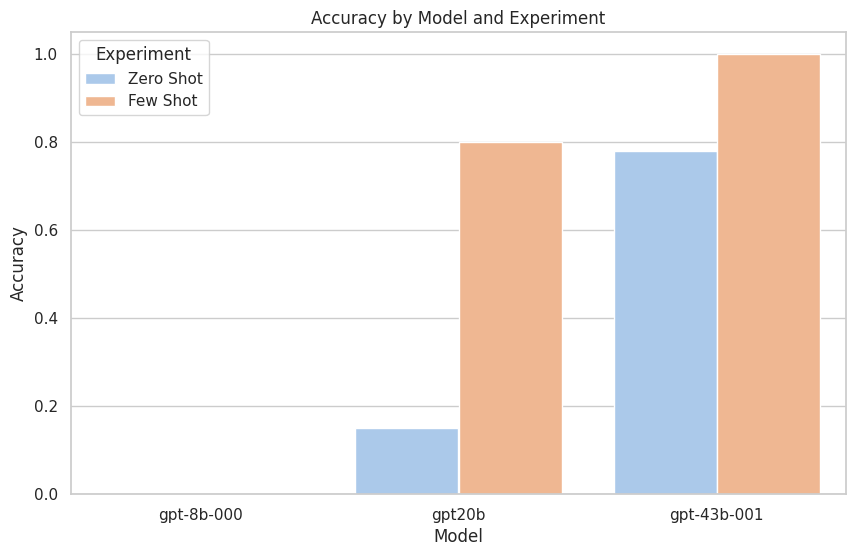

In [23]:
plot_experiment_results('./experiment_results/pubmed_experiment_results.csv')
# plot_experiment_results('./experiment_results/solutions/few_shot_pubmed_experiment_results.csv')

---

## Analysis

8B continues to not be up for the task at hand. 20B saw significant improvement with few-shot learning and 43B looks to have decreased in performance ever so slightly. This is interesting to notice and good to keep in mind, that while we have good guidelines to follow when it comes to customizing LLMs and their behavior, observation of empirical results is always critical.